In [1]:
import pandas as pd
import numpy as np
import re
from experiment_utils import get_latest_files
from post_processing import series_name, violin_plots_per_iteration, violin_plots, error_estimation, merge_estimates_true, compute_val_metrics, under_over_analysis, under_over_by_method, val_metrics_per_iteration, boxplots, boxplots_per_iteration, add_weights, exponential_weights_paper

Constants

In [2]:
pretty_methods = {'Holdout': 'Holdout', 
                'Repeated_Holdout': 'Repeated Holdout', 
                'Growing_Window': 'Growing Window', 
                'Rolling_Window': 'Rolling Window',
                'Block_CV': 'Block CV', 
                'AdaptedhvBlockCV': 'Adapted hv-Block CV', 
                'MarkovCV': 'Markov CV',
                'Block_CV_with_weights_paper': 'Weighted Block CV var.1', 
                'Block_CV_with_weights': 'Weighted Block CV var.2',
                'Growing_Window_with_weights': 'Weighted Growing Window', 
                'Rolling_Window_with_weights': 'Weighted Rolling Window'}

Functions

In [3]:
def clean_filename(filepath):
    filename = filepath.split('/')[-1]
    
    filename = filename.rsplit('.', 1)[0]
    
    # Check if the filename ends with a date in the format DDMMYYYY or similar
    # and remove the date if it exists
    filename = re.sub(r'_\d{8}$', '', filename)
    
    return filename

def clean_method(method_str):
    parts = method_str.split('.')
    if len(parts) > 3:
        method_name = parts[3].split()[0]
    else:
        method_name = parts[-1].split()[0]
    return method_name

def prettify(df, pretty_methods: dict = pretty_methods):
    copy = df.copy()
    copy['method'] = copy['method'].map(pretty_methods)
    return copy

## Upload Data

### Real Data

Be carefull with "get_latest_files" when lstm results are ready!

In [4]:
[get_latest_files('results/saude', 'table_A'), 
get_latest_files('results/transportes', 'table_A'), 
get_latest_files('results/eco_financas', 'table_A'), 
get_latest_files('results/eng_ciencias', 'table_A'), 
get_latest_files('results/energia', 'table_A'), 
get_latest_files('results/ambiente', 'table_A'), 
get_latest_files('results/meteorologia', 'table_A')]

['results/saude\\table_A_saude_2024_06_06__15_04_07.csv',
 'results/transportes\\table_A_transportes_2024_06_06__10_53_40.csv',
 'results/eco_financas\\table_A_eco_financas_2024_06_06__17_36_19.csv',
 'results/eng_ciencias\\table_A_eng_ciencias_2024_06_06__20_15_36.csv',
 'results/energia\\table_A_energia_2024_06_06__17_51_10.csv',
 'results/ambiente\\table_A_ambiente_2024_06_07__10_15_12.csv',
 'results/meteorologia\\table_A_meteorologia_2024_06_07__15_27_00.csv']

In [5]:
# Validation Results
saude = pd.read_csv('results/saude\\table_A_saude_2024_06_06__15_04_07.csv', dtype={'column_index': 'string'})
transportes = pd.read_csv('results/transportes\\table_A_transportes_2024_06_06__10_53_40.csv', dtype={'column_index': 'string'})
eco_financas = pd.read_csv('results/eco_financas\\table_A_eco_financas_2024_06_06__17_36_19.csv', dtype={'column_index': 'string'})
eng_ciencias = pd.read_csv('results/eng_ciencias\\table_A_eng_ciencias_2024_06_06__20_15_36.csv', dtype={'column_index': 'string'})
energia = pd.read_csv('results/energia\\table_A_energia_2024_06_06__17_51_10.csv', dtype={'column_index': 'string'})
ambiente = pd.read_csv('results/ambiente\\table_A_ambiente_2024_06_07__10_15_12.csv', dtype={'column_index': 'string'})
meteorologia = pd.read_csv('results/meteorologia\\table_A_meteorologia_2024_06_07__15_27_00.csv', dtype={'column_index': 'string'})

val_dict = {'saude': saude,
 'transportes': transportes,
 'eco_financas':eco_financas,
 'eng_ciencias': eng_ciencias,
 'energia': energia,
 'ambiente': ambiente,
 'meteorologia': meteorologia
 }

In [6]:
real_data_val = pd.concat(val_dict).reset_index(0).rename(columns={'level_0': 'Field'})
real_data_val

,Field,filename,column_index,method,iteration,model,mse,mae,rmse
0,saude,datasets/processed_data/covid19_17052024.csv,0,<timecave.validation_methods.OOS.Holdout objec...,0,Tree,1122.564394,20.017677,33.504692
1,saude,datasets/processed_data/covid19_17052024.csv,0,<timecave.validation_methods.OOS.Holdout objec...,0,ARMA,1097.670935,20.360957,33.131117
2,saude,datasets/processed_data/covid19_17052024.csv,0,<timecave.validation_methods.OOS.Repeated_Hold...,0,Tree,197.821429,8.396104,14.064901
3,saude,datasets/processed_data/covid19_17052024.csv,0,<timecave.validation_methods.OOS.Repeated_Hold...,0,ARMA,4652.950871,64.066829,68.212542
4,saude,datasets/processed_data/covid19_17052024.csv,0,<timecave.validation_methods.OOS.Repeated_Hold...,1,Tree,182.480132,8.099338,13.508521
...,...,...,...,...,...,...,...,...,...
2725,meteorologia,datasets/processed_data/MLTempDataset_13052024...,0,<timecave.validation_methods.markov.MarkovCV o...,7,ARMA,47.402579,5.636406,6.884953
2726,meteorologia,datasets/processed_data/MLTempDataset_13052024...,0,<timecave.validation_methods.markov.MarkovCV o...,8,Tree,63.853138,5.510571,7.990816
2727,meteorologia,datasets/processed_data/MLTempDataset_13052024...,0,<timecave.validation_methods.markov.MarkovCV o...,8,ARMA,52.510323,5.949948,7.246401
2728,meteorologia,datasets/processed_data/MLTempDataset_13052024...,0,<timecave.validation_methods.markov.MarkovCV o...,9,Tree,74.284770,6.082853,8.618861


In [7]:
[get_latest_files('results/saude', 'table_B'), 
get_latest_files('results/transportes', 'table_B'), 
get_latest_files('results/eco_financas', 'table_B'), 
get_latest_files('results/eng_ciencias', 'table_B'), 
get_latest_files('results/energia', 'table_B'), 
get_latest_files('results/ambiente', 'table_B'), 
get_latest_files('results/meteorologia', 'table_B')]

['results/saude\\table_B_saude_2024_06_06__15_04_07.csv',
 'results/transportes\\table_B_transportes_2024_06_06__10_53_40.csv',
 'results/eco_financas\\table_B_eco_financas_2024_06_06__17_36_19.csv',
 'results/eng_ciencias\\table_B_eng_ciencias_2024_06_06__20_15_36.csv',
 'results/energia\\table_B_energia_2024_06_06__17_51_10.csv',
 'results/ambiente\\table_B_ambiente_2024_06_07__10_15_12.csv',
 'results/meteorologia\\table_B_meteorologia_2024_06_07__15_27_00.csv']

In [8]:
# Test Results
saude_test = pd.read_csv('results/saude\\table_B_saude_2024_06_06__15_04_07.csv', dtype={'column_index': 'string'})
transportes_test = pd.read_csv('results/transportes\\table_B_transportes_2024_06_06__10_53_40.csv', dtype={'column_index': 'string'})
eco_financas_test = pd.read_csv('results/eco_financas\\table_B_eco_financas_2024_06_06__17_36_19.csv', dtype={'column_index': 'string'})
eng_ciencias_test = pd.read_csv('results/eng_ciencias\\table_B_eng_ciencias_2024_06_06__20_15_36.csv', dtype={'column_index': 'string'})
energia_test = pd.read_csv('results/energia\\table_B_energia_2024_06_06__17_51_10.csv', dtype={'column_index': 'string'})
ambiente_test = pd.read_csv('results/ambiente\\table_B_ambiente_2024_06_07__10_15_12.csv', dtype={'column_index': 'string'})
meteorologia_test = pd.read_csv('results/meteorologia\\table_B_meteorologia_2024_06_07__15_27_00.csv', dtype={'column_index': 'string'})

test_dict = {'saude': saude_test,
 'transportes': transportes_test,
 'eco_financas':eco_financas_test,
 'eng_ciencias': eng_ciencias_test,
 'energia': energia_test,
 'ambiente': ambiente_test,
 'meteorologia': meteorologia_test
 }

In [9]:
real_data_test = pd.concat(test_dict).reset_index(0).rename(columns={'level_0': 'Field'})
real_data_test

,Field,filename,column_index,model,mse,mae,rmse
0,saude,datasets/processed_data/covid19_17052024.csv,0,Tree,17.316252,2.493517,4.161280
1,saude,datasets/processed_data/covid19_17052024.csv,0,ARMA,35.113134,5.037637,5.925634
2,saude,datasets/processed_data/covid19_17052024.csv,1,Tree,5.463435,1.555446,2.337399
3,saude,datasets/processed_data/covid19_17052024.csv,1,ARMA,14.434002,3.375995,3.799211
4,saude,datasets/processed_data/covid19_17052024.csv,2,Tree,8.104641,1.812699,2.846865
...,...,...,...,...,...,...,...
65,meteorologia,datasets/processed_data/jena_climate_data.csv,12,ARMA,23783.710487,4.231992,154.219683
66,meteorologia,datasets/processed_data/jena_climate_data.csv,13,Tree,6025.325689,40.736198,77.622971
67,meteorologia,datasets/processed_data/jena_climate_data.csv,13,ARMA,7167.891640,68.984216,84.663402
68,meteorologia,datasets/processed_data/MLTempDataset_13052024...,0,Tree,10.731559,1.387957,3.275906


### Synthetic Data

In [10]:
[get_latest_files('results/s1', 'table_A'), 
get_latest_files('results/s2', 'table_A'), 
get_latest_files('results/s3', 'table_A')]

['results/s1\\table_A_s1_414_1000_LSTM_2024_06_19__12_57_51.csv',
 'results/s2\\table_A_s2_645_1000_LSTM_2024_06_21__12_32_08.csv',
 'results/s3\\table_A_s3_2024_06_07__17_30_48.csv']

In [11]:
# Validation Results
s1_1 = pd.read_csv('results/s1\\table_A_s1_0_200_2024_06_07__11_28_28.csv', dtype={'column_index': 'string'})
s1_2 = pd.read_csv('results/s1\\table_A_s1_200_1001_2024_06_07__12_00_51.csv', dtype={'column_index': 'string'})
s2_1 = pd.read_csv('results/s2\\table_A_s2_0_200_2024_06_07__11_38_43.csv', dtype={'column_index': 'string'})
s2_2 = pd.read_csv('results/s2\\table_A_s2_200_1001_2024_06_07__12_11_58.csv', dtype={'column_index': 'string'})
s3 = pd.read_csv('results/s3\\table_A_s3_2024_06_07__17_30_48.csv', dtype={'column_index': 'string'})

val_dict = {
's1': s1_1,
's1_2': s1_2,
's2': s2_1,
's2_2': s2_2,
's3':s3
 }

In [12]:
syn_data_val = pd.concat(val_dict).reset_index(0).rename(columns={'level_0': 'Field'})
syn_data_val['Field'] = syn_data_val['Field'].map({'s1': 's1', 's2': 's2','s1_2': 's1', 's2_2': 's2', 's3': 's3'})
syn_data_val

,Field,filename,column_index,method,iteration,model,mse,mae,rmse
0,s1,datasets/synthetic_data/s1.csv,0,<timecave.validation_methods.OOS.Holdout objec...,0,Tree,2.290200e+00,1.212833,1.513341
1,s1,datasets/synthetic_data/s1.csv,0,<timecave.validation_methods.OOS.Holdout objec...,0,ARMA,1.747274e+00,1.008874,1.321845
2,s1,datasets/synthetic_data/s1.csv,0,<timecave.validation_methods.OOS.Repeated_Hold...,0,Tree,2.557555e+00,1.351258,1.599236
3,s1,datasets/synthetic_data/s1.csv,0,<timecave.validation_methods.OOS.Repeated_Hold...,0,ARMA,1.652459e+00,1.030527,1.285480
4,s1,datasets/synthetic_data/s1.csv,0,<timecave.validation_methods.OOS.Repeated_Hold...,1,Tree,3.059749e+00,1.464176,1.749214
...,...,...,...,...,...,...,...,...,...
77995,s3,datasets/synthetic_data/s3.csv,999,<timecave.validation_methods.markov.MarkovCV o...,7,ARMA,2.617459e+07,4236.730735,5116.110406
77996,s3,datasets/synthetic_data/s3.csv,999,<timecave.validation_methods.markov.MarkovCV o...,8,Tree,1.958592e+06,1370.483420,1399.497139
77997,s3,datasets/synthetic_data/s3.csv,999,<timecave.validation_methods.markov.MarkovCV o...,8,ARMA,5.514686e+06,1990.997347,2348.336855
77998,s3,datasets/synthetic_data/s3.csv,999,<timecave.validation_methods.markov.MarkovCV o...,9,Tree,8.393755e+05,806.445944,916.174364


In [13]:
[get_latest_files('results/s1', 'table_B'), 
get_latest_files('results/s2', 'table_B'), 
get_latest_files('results/s3', 'table_B')]

['results/s1\\table_B_s1_414_1000_LSTM_2024_06_19__12_57_51.csv',
 'results/s2\\table_B_s2_645_1000_LSTM_2024_06_21__12_32_08.csv',
 'results/s3\\table_B_s3_2024_06_07__17_30_48.csv']

In [14]:
# Test Results
s1_1_test = pd.read_csv('results/s1\\table_B_s1_0_200_2024_06_07__11_28_28.csv', dtype={'column_index': 'string'})
s1_2_test = pd.read_csv('results/s1\\table_B_s1_200_1001_2024_06_07__12_00_51.csv', dtype={'column_index': 'string'})
s2_1_test = pd.read_csv('results/s2\\table_B_s2_0_200_2024_06_07__11_38_43.csv', dtype={'column_index': 'string'})
s2_2_test = pd.read_csv('results/s2\\table_B_s2_200_1001_2024_06_07__12_11_58.csv', dtype={'column_index': 'string'})
s3_test = pd.read_csv('results/s3\\table_B_s3_2024_06_07__17_30_48.csv', dtype={'column_index': 'string'})

test_dict = {
's1': s1_1_test,
's1_2': s1_2_test,
's2': s2_1_test,
's2_2': s2_2_test,
's3':s3_test
 }

In [15]:
syn_data_test = pd.concat(test_dict).reset_index(0).rename(columns={'level_0': 'Field'})
syn_data_test['Field'] = syn_data_test['Field'].map({'s1': 's1', 's2': 's2','s1_2': 's1', 's2_2': 's2', 's3': 's3'})
syn_data_test

,Field,filename,column_index,model,mse,mae,rmse
0,s1,datasets/synthetic_data/s1.csv,0,Tree,2.239900e+00,1.216184,1.496630
1,s1,datasets/synthetic_data/s1.csv,0,ARMA,2.726234e+00,1.342448,1.651131
2,s1,datasets/synthetic_data/s1.csv,1,Tree,6.658242e+00,2.083506,2.580357
3,s1,datasets/synthetic_data/s1.csv,1,ARMA,1.337243e+01,2.930200,3.656833
4,s1,datasets/synthetic_data/s1.csv,2,Tree,1.130832e+01,2.703739,3.362784
...,...,...,...,...,...,...,...
1995,s3,datasets/synthetic_data/s3.csv,997,ARMA,9.453888e+05,780.109492,972.311062
1996,s3,datasets/synthetic_data/s3.csv,998,Tree,1.586311e+06,852.319457,1259.488341
1997,s3,datasets/synthetic_data/s3.csv,998,ARMA,5.073560e+06,1714.979950,2252.456450
1998,s3,datasets/synthetic_data/s3.csv,999,Tree,2.658804e+06,1431.174835,1630.583863


# Analysing Results

In [16]:
data_val, data_test = real_data_val, real_data_test

### Preprocessing results

In [17]:
data_val['filename'] = data_val['filename'].apply(clean_filename)
data_val['method'] = data_val['method'].apply(clean_method)
data_val = series_name(data_val)
data_val

,series,Field,method,iteration,model,mse,mae,rmse
0,covid19_0,saude,Holdout,0,Tree,1122.564394,20.017677,33.504692
1,covid19_0,saude,Holdout,0,ARMA,1097.670935,20.360957,33.131117
2,covid19_0,saude,Repeated_Holdout,0,Tree,197.821429,8.396104,14.064901
3,covid19_0,saude,Repeated_Holdout,0,ARMA,4652.950871,64.066829,68.212542
4,covid19_0,saude,Repeated_Holdout,1,Tree,182.480132,8.099338,13.508521
...,...,...,...,...,...,...,...,...
2725,MLTempDataset_0,meteorologia,MarkovCV,7,ARMA,47.402579,5.636406,6.884953
2726,MLTempDataset_0,meteorologia,MarkovCV,8,Tree,63.853138,5.510571,7.990816
2727,MLTempDataset_0,meteorologia,MarkovCV,8,ARMA,52.510323,5.949948,7.246401
2728,MLTempDataset_0,meteorologia,MarkovCV,9,Tree,74.284770,6.082853,8.618861


In [18]:
data_test['filename'] = data_test['filename'].apply(clean_filename)
data_test = series_name(data_test)
data_test

,series,Field,model,mse,mae,rmse
0,covid19_0,saude,Tree,17.316252,2.493517,4.161280
1,covid19_0,saude,ARMA,35.113134,5.037637,5.925634
2,covid19_1,saude,Tree,5.463435,1.555446,2.337399
3,covid19_1,saude,ARMA,14.434002,3.375995,3.799211
4,covid19_2,saude,Tree,8.104641,1.812699,2.846865
...,...,...,...,...,...,...
65,jena_climate_data_12,meteorologia,ARMA,23783.710487,4.231992,154.219683
66,jena_climate_data_13,meteorologia,Tree,6025.325689,40.736198,77.622971
67,jena_climate_data_13,meteorologia,ARMA,7167.891640,68.984216,84.663402
68,MLTempDataset_0,meteorologia,Tree,10.731559,1.387957,3.275906


In [19]:
data_val = add_weights(data_val, preq_methods = ['Growing_Window', 'Rolling_Window'], CV_methods = ['Block_CV'])
data_val

,series,Field,method,iteration,model,mse,mae,rmse,weights
0,covid19_0,saude,Holdout,0,Tree,1122.564394,20.017677,33.504692,1.000000
1,covid19_0,saude,Holdout,0,ARMA,1097.670935,20.360957,33.131117,1.000000
2,covid19_0,saude,Repeated_Holdout,0,Tree,197.821429,8.396104,14.064901,1.000000
3,covid19_0,saude,Repeated_Holdout,0,ARMA,4652.950871,64.066829,68.212542,1.000000
4,covid19_0,saude,Repeated_Holdout,1,Tree,182.480132,8.099338,13.508521,1.000000
...,...,...,...,...,...,...,...,...,...
30547,MLTempDataset_0,meteorologia,Rolling_Window_with_weights,3,ARMA,37.253910,5.738725,6.103598,0.266667
30548,MLTempDataset_0,meteorologia,Rolling_Window_with_weights,1,Tree,17.250183,2.400754,4.153334,0.066667
30549,MLTempDataset_0,meteorologia,Rolling_Window_with_weights,1,ARMA,90.979230,7.153370,9.538303,0.066667
30550,MLTempDataset_0,meteorologia,Rolling_Window_with_weights,2,Tree,15.219104,2.088351,3.901167,0.133333


### Results

#### Tables

In [20]:
est_data_val = error_estimation(data_val)
est_data_val

,series,method,model,mse,mae
0,DailyDelhiClimate_0,AdaptedhvBlockCV,ARMA,80.749119,7.123344
1,DailyDelhiClimate_0,AdaptedhvBlockCV,Tree,5.906699,1.836843
2,DailyDelhiClimate_0,Block_CV,ARMA,80.503973,7.126233
3,DailyDelhiClimate_0,Block_CV,Tree,5.770700,1.850585
4,DailyDelhiClimate_0,Block_CV_with_weights,ARMA,70.206565,6.978417
...,...,...,...,...,...
5891,traffic_2,Repeated_Holdout,Tree,86.013504,5.127104
5892,traffic_2,Rolling_Window,ARMA,124.217230,6.575690
5893,traffic_2,Rolling_Window,Tree,77.258662,4.932268
5894,traffic_2,Rolling_Window_with_weights,ARMA,136.505696,6.756850


In [21]:
estimates = merge_estimates_true(est_data_val, data_test)
all_metrics = compute_val_metrics(estimates, 'mse')
all_metrics

,Mean,Median,1st_Quartile,3rd_Quartile,Minimum,Maximum,Standard_deviation,method,model,metric
0,-5.433608e+04,-1.018647e-08,-9.248379,21.211298,-1.144028e+07,1.155448e+07,1.235702e+06,AdaptedhvBlockCV,ARMA,PAE
1,1.643869e+05,1.557018e+01,0.275742,313.267122,2.061709e-08,1.155448e+07,1.225924e+06,AdaptedhvBlockCV,ARMA,APAE
2,8.399858e-01,2.647597e-03,-0.217666,0.674698,-9.998897e-01,2.154360e+01,2.790535e+00,AdaptedhvBlockCV,ARMA,RPAE
3,1.131530e+00,3.192090e-01,0.124873,0.806448,2.307294e-03,2.154360e+01,2.685573e+00,AdaptedhvBlockCV,ARMA,RAPAE
4,1.063404e-01,2.631870e-03,-0.244249,0.504504,-1.999559e+00,1.830102e+00,7.108546e-01,AdaptedhvBlockCV,ARMA,sMPAE
...,...,...,...,...,...,...,...,...,...,...
105,2.374848e+04,1.007932e-02,-0.116593,26.387536,-6.238061e+05,4.501483e+06,2.969090e+05,Rolling_Window_with_weights,Tree,PAE
106,3.201758e+04,4.571309e+00,0.041059,132.920894,5.523761e-09,4.501483e+06,2.961314e+05,Rolling_Window_with_weights,Tree,APAE
107,9.972147e+06,9.459921e-02,-0.059811,2.031860,-9.999716e-01,2.672519e+09,1.629452e+08,Rolling_Window_with_weights,Tree,RPAE
108,9.972147e+06,3.693153e-01,0.070694,2.031860,9.662739e-04,2.672519e+09,1.629452e+08,Rolling_Window_with_weights,Tree,RAPAE


In [22]:
under_over_analysis(estimates, 'mse')[0]

,Mean,Median,1st_Quartile,3rd_Quartile,Minimum,Maximum,Standard_deviation,N,%,method,model,metric
0,-218722.969059,-9.567709,-208.844791,-0.042103,-1.144028e+07,-4.099003e-08,1.403351e+06,134,50.00,AdaptedhvBlockCV,ARMA,PAE
1,218722.969059,9.567709,0.042103,208.844791,4.099003e-08,1.144028e+07,1.403351e+06,134,50.00,AdaptedhvBlockCV,ARMA,APAE
2,-0.291544,-0.218193,-0.419208,-0.083621,-9.998897e-01,-2.307294e-03,2.575039e-01,134,50.00,AdaptedhvBlockCV,ARMA,RPAE
3,0.291544,0.218193,0.083621,0.419208,2.307294e-03,9.998897e-01,2.575039e-01,134,50.00,AdaptedhvBlockCV,ARMA,RAPAE
4,-9327.162118,-4.148268,-80.991599,-0.001293,-7.023322e+05,-6.855162e-08,6.568306e+04,132,49.25,AdaptedhvBlockCV,Tree,PAE
...,...,...,...,...,...,...,...,...,...,...,...,...
83,0.289531,0.176816,0.071158,0.440175,1.886088e-03,9.998895e-01,2.709657e-01,130,48.51,Rolling_Window_with_weights,ARMA,RAPAE
84,-11192.522591,-3.272943,-41.582172,-0.027188,-6.238061e+05,-5.523761e-09,6.905951e+04,99,36.94,Rolling_Window_with_weights,Tree,PAE
85,11192.522591,3.272943,0.027188,41.582172,5.523761e-09,6.238061e+05,6.905951e+04,99,36.94,Rolling_Window_with_weights,Tree,APAE
86,-0.250228,-0.153635,-0.361236,-0.048011,-9.999716e-01,-9.662739e-04,2.749584e-01,99,36.94,Rolling_Window_with_weights,Tree,RPAE


In [23]:
under_over_by_method(estimates, 'mse')

(             Mean     Median  1st_Quartile  3rd_Quartile       Minimum  \
 0  -114812.267870  -5.479489    -99.096697     -0.003718 -1.144028e+07   
 1   114812.267870   5.479489      0.003718     99.096697  4.099003e-08   
 2       -0.291332  -0.212645     -0.414107     -0.071942 -9.999709e-01   
 3        0.291332   0.212645      0.071942      0.414107  1.170280e-03   
 4  -114123.665650  -6.668913    -94.953504     -0.004632 -1.143580e+07   
 5   114123.665650   6.668913      0.004632     94.953504  4.373907e-08   
 6       -0.288347  -0.193704     -0.407933     -0.069610 -9.999708e-01   
 7        0.288347   0.193704      0.069610      0.407933  1.352814e-03   
 8   -65380.545566  -3.844774   -101.263989     -0.019662 -1.041102e+07   
 9    65380.545566   3.844774      0.019662    101.263989  4.543140e-10   
 10      -0.268624  -0.158496     -0.393251     -0.056072 -9.999713e-01   
 11       0.268624   0.158496      0.056072      0.393251  4.520206e-04   
 12  -68678.484728  -4.57

In [24]:
iteration_data = pd.merge(left=data_val, right=data_test, on=["model", "series"], suffixes=["_estimate", "_true"]);

In [25]:
metrics = val_metrics_per_iteration(iteration_data, 'mse', methods_list=['Block_CV_with_weights', 'Block_CV'])
metrics

method model iteration            PAE                \
                                                    mean        median   
0                Block_CV  ARMA         0  -69045.600512  3.343253e-09   
1                Block_CV  ARMA         1 -192123.670995 -1.265798e-05   
2                Block_CV  ARMA         2 -221820.542287 -5.815741e-06   
3                Block_CV  ARMA         3  391532.370607 -2.185165e-06   
4                Block_CV  ARMA         4 -180605.830918 -1.687389e-06   
5                Block_CV  Tree         0    -201.980196 -1.206874e-05   
6                Block_CV  Tree         1   -6465.695919 -1.611041e-05   
7                Block_CV  Tree         2   -3410.263314 -4.860910e-07   
8                Block_CV  Tree         3   15139.304439 -9.544171e-07   
9                Block_CV  Tree         4   -5980.025983 -5.564862e-08   
10  Block_CV_with_weights  ARMA         1 -192123.670995 -1.265798e-05   
11  Block_CV_with_weights  ARMA         2 -221820.542287 -5.815741e-06   
12  Block_CV_with_weights  ARMA         3  391532.370607 -2.185165e-06   
13  Block_CV_with_weights  ARMA         4 -180605.830918 -1.687389e-06   
14  Block_CV_with_weights  Tree         1   -6465.695919 -1.611041e-05   
15  Block_CV_with_weights  Tree         2   -3410.263314 -4.860910e-07   
16  Block_CV_with_weights  Tree         3   15139.304439 -9.544171e-07   
17  Block_CV_with_weights  Tree         4   -5980.025983 -5.564862e-08   

                                                       APAE             ...  \
             min           max           std           mean     median  ...   
0  -3.827297e+07  3.675029e+07  3.424511e+06  400223.327168  21.314314  ...   
1  -3.851710e+07  1.321823e+07  2.670828e+06  291786.969485  14.684595  ...   
2  -3.685860e+07  1.857112e+06  2.548486e+06  239917.439199  12.403180  ...   
3  -1.815110e+06  7.660159e+07  4.791290e+06  411575.624322   7.549466  ...   
4  -2.013193e+07  3.212095e+06  1.748343e+06  206992.265159  13.070432  ...   
5  -1.063718e+06  1.231192e+06  1.134965e+05   16417.089477   4.349960  ...   
6  -7.488521e+05  1.994141e+05  6.175217e+04    8994.773447   4.844006  ...   
7  -3.999467e+05  1.085788e+05  3.906912e+04    5886.806506   3.453258  ...   
8  -1.036149e+06  2.652947e+06  2.300178e+05   27306.691008   4.221070  ...   
9  -9.779661e+05  5.912710e+04  6.677724e+04    7992.253106   3.124441  ...   
10 -3.851710e+07  1.321823e+07  2.670828e+06  291786.969485  14.684595  ...   
11 -3.685860e+07  1.857112e+06  2.548486e+06  239917.439199  12.403180  ...   
12 -1.815110e+06  7.660159e+07  4.791290e+06  411575.624322   7.549466  ...   
13 -2.013193e+07  3.212095e+06  1.748343e+06  206992.265159  13.070432  ...   
14 -7.488521e+05  1.994141e+05  6.175217e+04    8994.773447   4.844006  ...   
15 -3.999467e+05  1.085788e+05  3.906912e+04    5886.806506   3.453258  ...   
16 -1.036149e+06  2.652947e+06  2.300178e+05   27306.691008   4.221070  ...   
17 -9.779661e+05  5.912710e+04  6.677724e+04    7992.253106   3.124441  ...   

           RPAE                                                        RAPAE  \
           mean    median       min           max           std         mean   
0      1.378819  0.001567 -0.999894  7.484983e+01      6.775426     1.796267   
1      0.479398 -0.083894 -0.999897  2.285743e+01      2.224930     0.915646   
2      0.621909 -0.048591 -0.999894  3.155692e+01      2.802723     1.048409   
3      0.741380 -0.027706 -0.999894  5.402977e+01      4.450140     1.113571   
4      0.908723 -0.039256 -0.999890  5.080857e+01      5.132965     1.288275   
5      4.435561 -0.071733 -0.999970  2.895870e+02     25.804346     4.942723   
6   5053.919705 -0.060622 -0.999995  1.354201e+06  82720.946317  5054.435523   
7     12.935801 -0.019719 -0.999991  9.570389e+02     92.810286    13.333749   
8   5054.995990 -0.027233 -0.999971  1.354201e+06  82720.883187  5055.419954   
9      1.006222 -0.003951 -0.999972  4.684521e+01      4.606524     1.305701 

#### Graphs

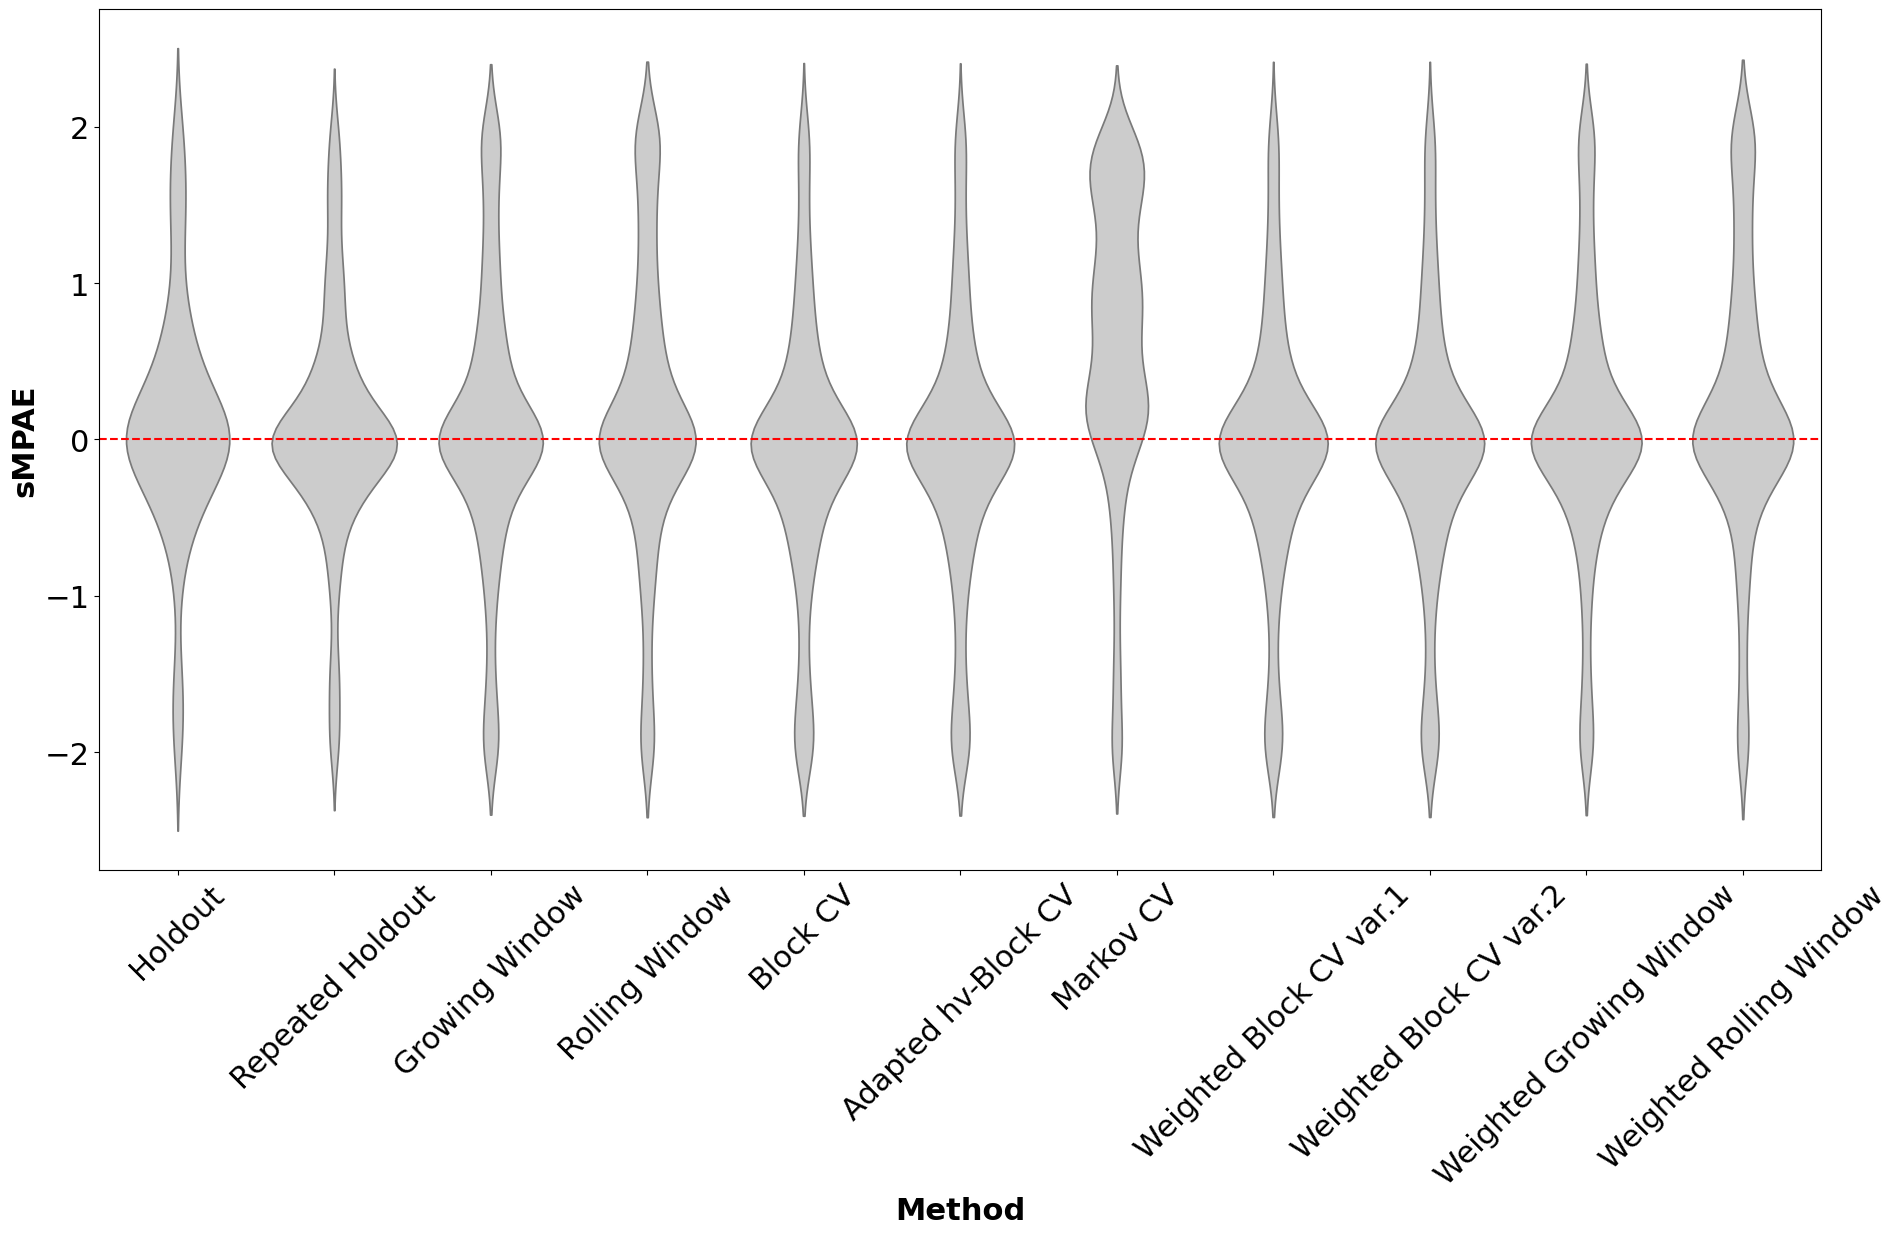

In [26]:
methods = ['Holdout']
it = iteration_data.loc[iteration_data["method"].isin(methods)].copy()
violin_plots(prettify(iteration_data), "mse", "Tree", ["sMPAE"], 10, 20)

In [27]:
methods = ['Block_CV', 'Block_CV_with_weights_paper']
it = iteration_data.loc[iteration_data["method"].isin(methods)].copy()
it

,series,Field_estimate,method,iteration,model,mse_estimate,mae_estimate,rmse_estimate,weights,Field_true,mse_true,mae_true,rmse_true
38,covid19_0,saude,Block_CV,0,Tree,25.500000,4.100000,5.049752,1.0000,saude,17.316252,2.493517,4.161280
39,covid19_0,saude,Block_CV,0,ARMA,36.902909,5.593245,6.074776,1.0000,saude,35.113134,5.037637,5.925634
40,covid19_0,saude,Block_CV,1,Tree,127.334402,7.414103,11.284255,1.0000,saude,17.316252,2.493517,4.161280
41,covid19_0,saude,Block_CV,1,ARMA,153.787160,9.407495,12.401095,1.0000,saude,35.113134,5.037637,5.925634
42,covid19_0,saude,Block_CV,2,Tree,79.861538,6.384615,8.936528,1.0000,saude,17.316252,2.493517,4.161280
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23043,MLTempDataset_0,meteorologia,Block_CV_with_weights_paper,2,ARMA,72.765283,7.896898,8.530257,0.0625,meteorologia,29.436384,4.758570,5.425531
23044,MLTempDataset_0,meteorologia,Block_CV_with_weights_paper,3,Tree,13.628610,1.920266,3.691695,0.1250,meteorologia,10.731559,1.387957,3.275906
23045,MLTempDataset_0,meteorologia,Block_CV_with_weights_paper,3,ARMA,67.975158,6.749322,8.244705,0.1250,meteorologia,29.436384,4.758570,5.425531
23046,MLTempDataset_0,meteorologia,Block_CV_with_weights_paper,4,Tree,12.943231,1.703865,3.597670,0.2500,meteorologia,10.731559,1.387957,3.275906


c:\Users\User\Desktop\Project_repos\tsvalidation\tsvalidation\experiments\post_processing.py:348: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig = boxplot[0].get_figure() if isinstance(boxplot, pd.Series) else boxplot[0, 0].get_figure()


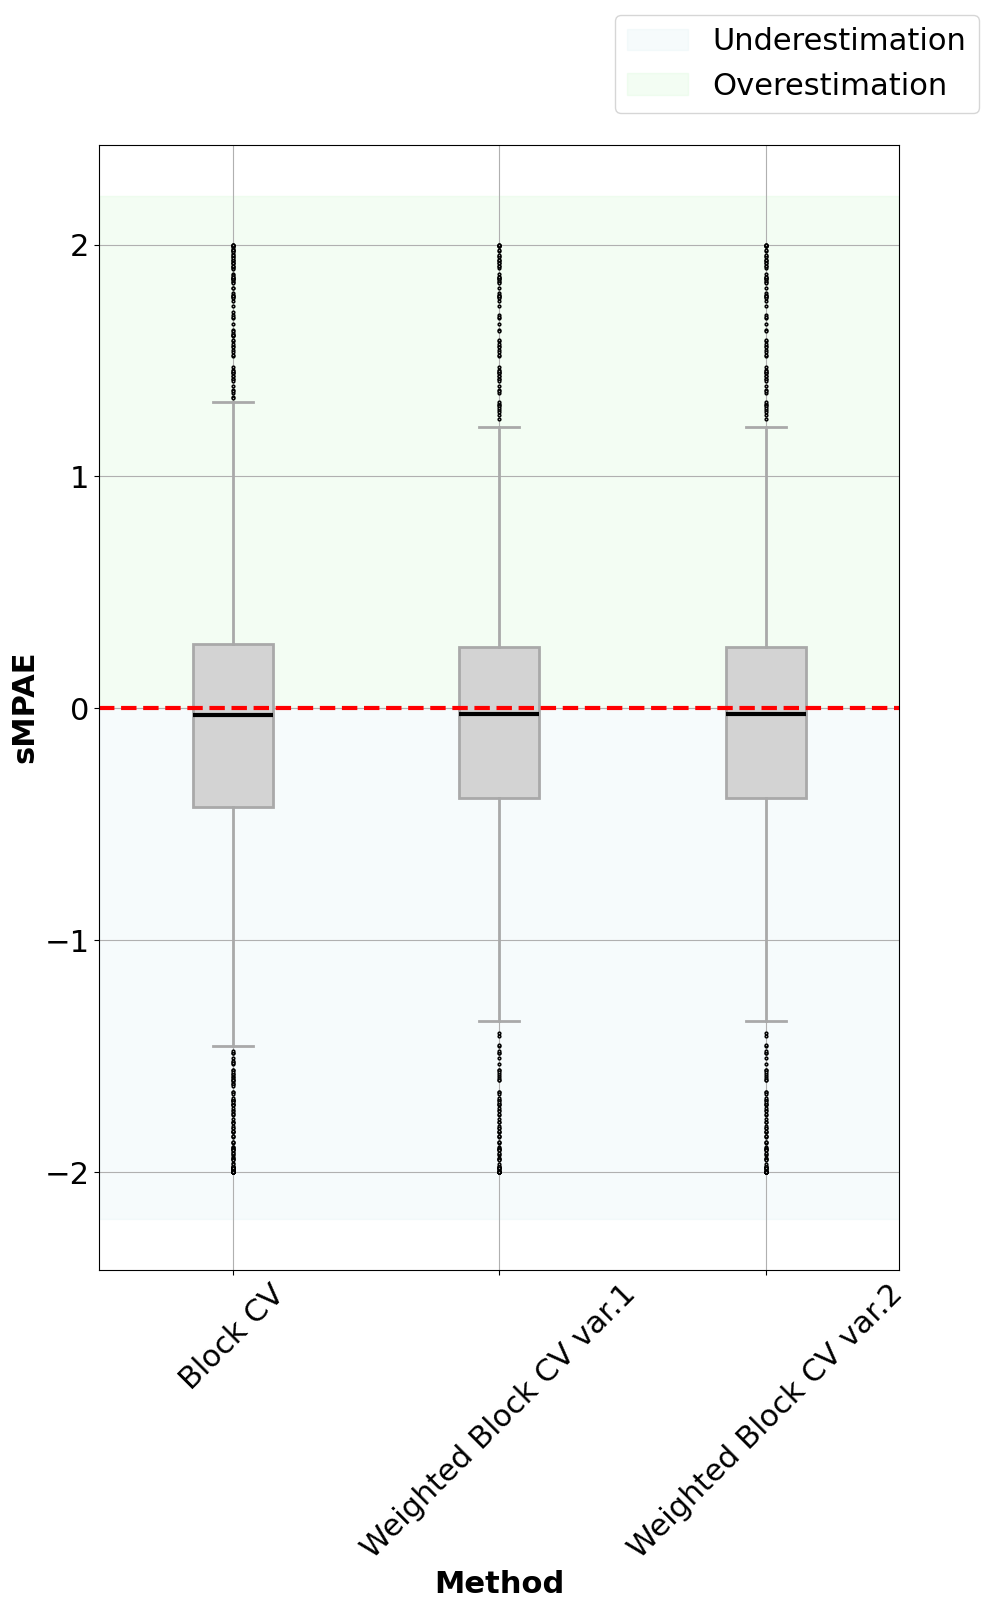

In [28]:
methods = ['Block_CV', 'Block_CV_with_weights_paper', 'Block_CV_with_weights']
it = iteration_data.loc[iteration_data["method"].isin(methods)].copy()
boxplots(prettify(it), "mse", "Tree", ["sMPAE"], 15, 10, shows_outliers=True)

In [29]:
iteration_data.method.unique()
iteration_data.loc[iteration_data["method"].isin(methods)].copy()

,series,Field_estimate,method,iteration,model,mse_estimate,mae_estimate,rmse_estimate,weights,Field_true,mse_true,mae_true,rmse_true
38,covid19_0,saude,Block_CV,0,Tree,25.500000,4.100000,5.049752,1.000000,saude,17.316252,2.493517,4.161280
39,covid19_0,saude,Block_CV,0,ARMA,36.902909,5.593245,6.074776,1.000000,saude,35.113134,5.037637,5.925634
40,covid19_0,saude,Block_CV,1,Tree,127.334402,7.414103,11.284255,1.000000,saude,17.316252,2.493517,4.161280
41,covid19_0,saude,Block_CV,1,ARMA,153.787160,9.407495,12.401095,1.000000,saude,35.113134,5.037637,5.925634
42,covid19_0,saude,Block_CV,2,Tree,79.861538,6.384615,8.936528,1.000000,saude,17.316252,2.493517,4.161280
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25187,MLTempDataset_0,meteorologia,Block_CV_with_weights,2,ARMA,72.765283,7.896898,8.530257,0.064516,meteorologia,29.436384,4.758570,5.425531
25188,MLTempDataset_0,meteorologia,Block_CV_with_weights,3,Tree,13.628610,1.920266,3.691695,0.129032,meteorologia,10.731559,1.387957,3.275906
25189,MLTempDataset_0,meteorologia,Block_CV_with_weights,3,ARMA,67.975158,6.749322,8.244705,0.129032,meteorologia,29.436384,4.758570,5.425531
25190,MLTempDataset_0,meteorologia,Block_CV_with_weights,4,Tree,12.943231,1.703865,3.597670,0.258065,meteorologia,10.731559,1.387957,3.275906


c:\Users\User\Desktop\Project_repos\tsvalidation\tsvalidation\experiments\post_processing.py:348: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig = boxplot[0].get_figure() if isinstance(boxplot, pd.Series) else boxplot[0, 0].get_figure()


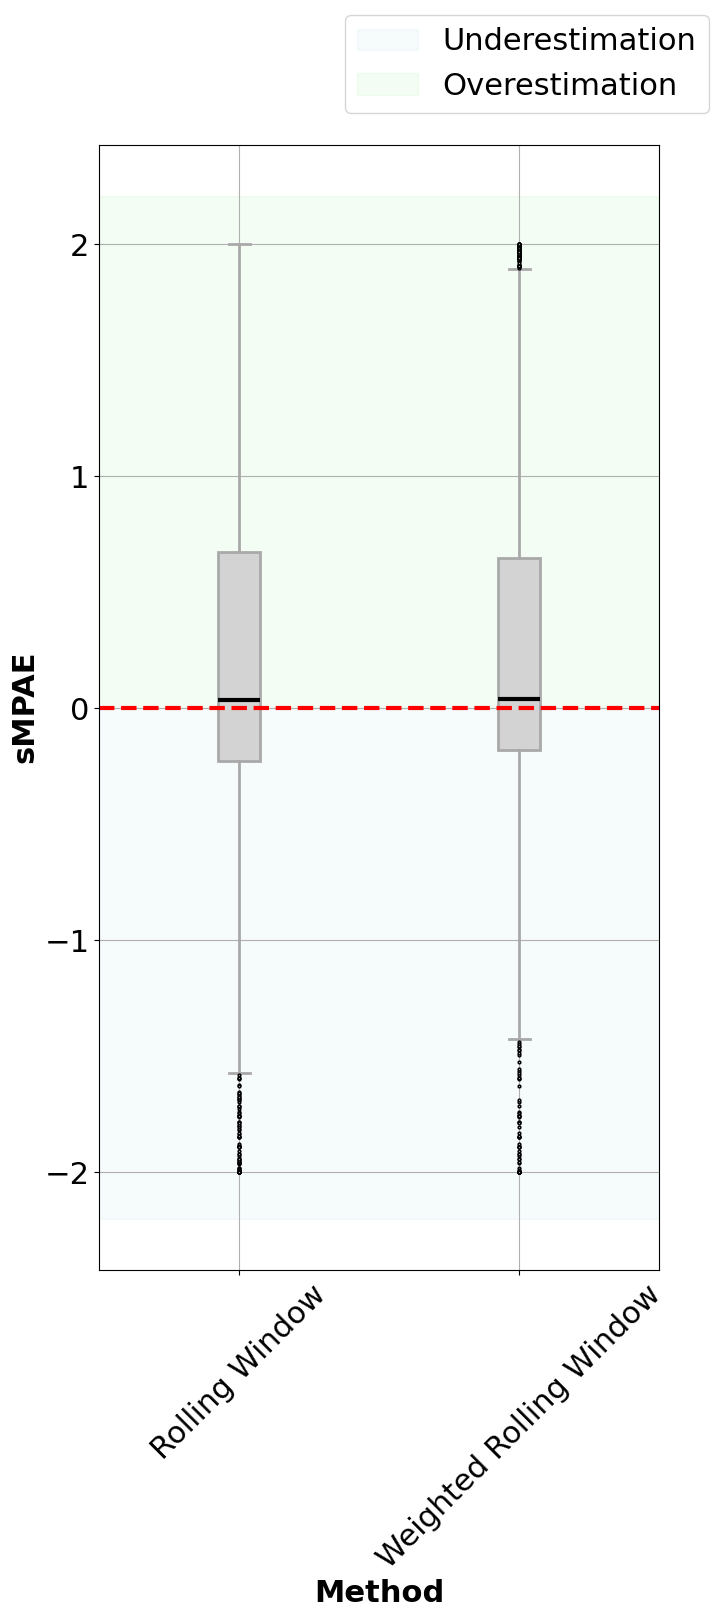

In [30]:
methods = ['Rolling_Window','Rolling_Window_with_weights']
it = iteration_data.loc[iteration_data["method"].isin(methods)].copy()
boxplots(prettify(it), "mse", "Tree", ["sMPAE"], 15, 7, shows_outliers=True)

c:\Users\User\Desktop\Project_repos\tsvalidation\tsvalidation\experiments\post_processing.py:348: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig = boxplot[0].get_figure() if isinstance(boxplot, pd.Series) else boxplot[0, 0].get_figure()


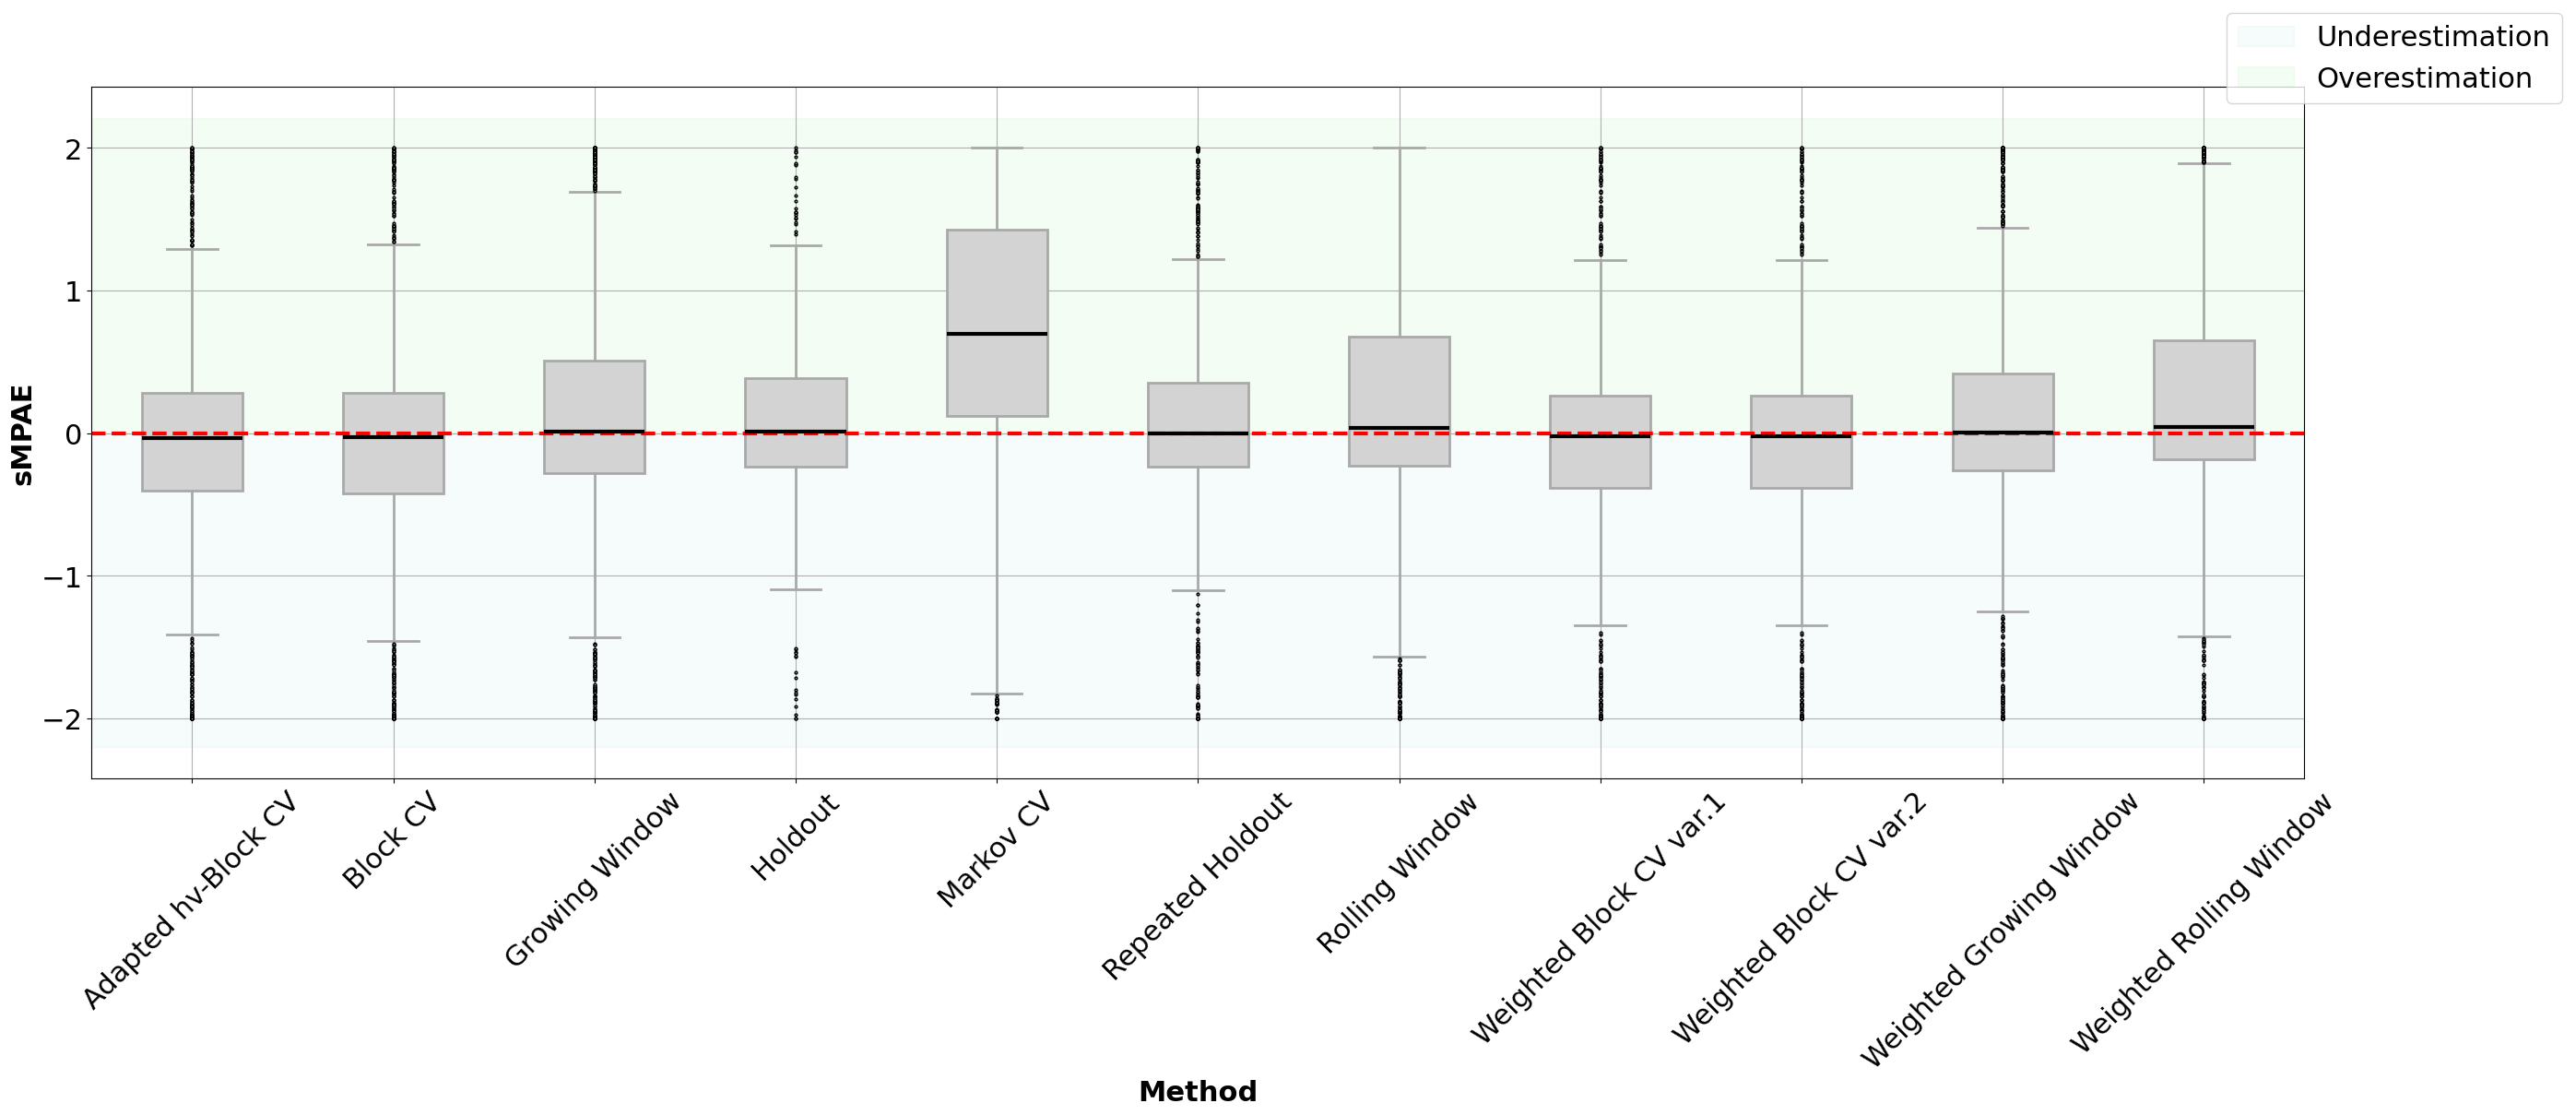

In [36]:
methods = ['Holdout', 'Repeated Holdout']
it = iteration_data.loc[iteration_data["method"].isin(methods)].copy()
boxplots(prettify(iteration_data), "mse", "Tree", ["sMPAE"], 10, 30, shows_outliers=True)

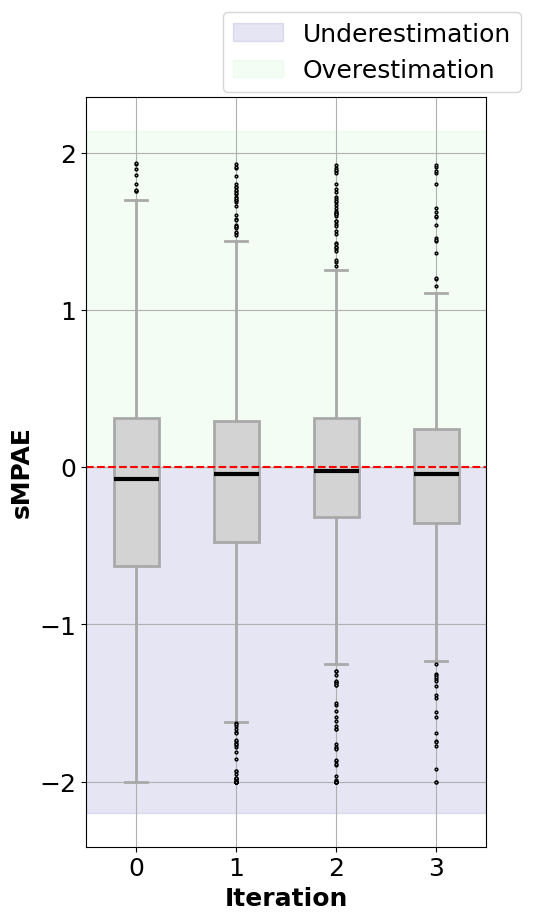

In [32]:
boxplots_per_iteration(prettify(iteration_data), "mse", "ARMA", pretty_methods["Growing_Window"], ["sMPAE"], 10, 5);

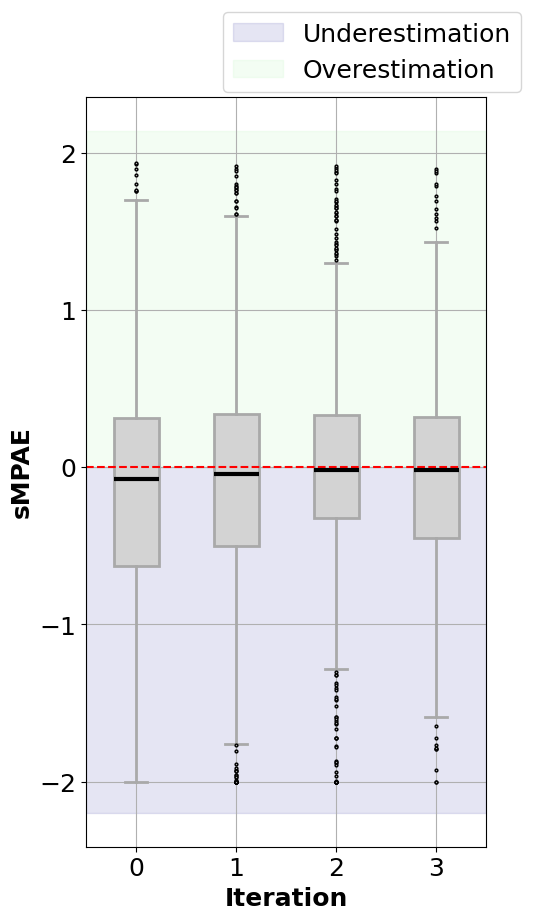

In [33]:
boxplots_per_iteration(prettify(iteration_data), "mse", "ARMA", pretty_methods["Rolling_Window"], ["sMPAE"], 10, 5);

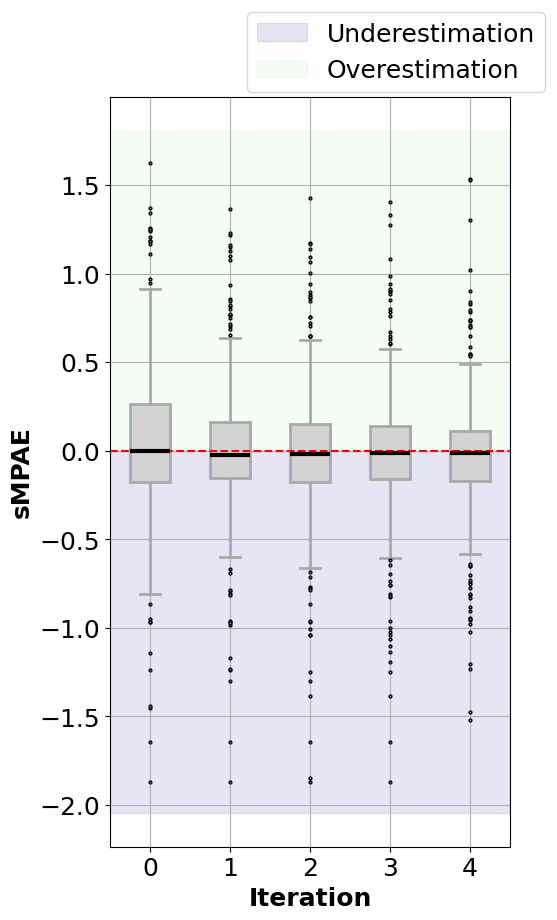

In [34]:
boxplots_per_iteration(prettify(iteration_data), "mae", "ARMA", pretty_methods["Block_CV"], ["sMPAE"], 10, 5);

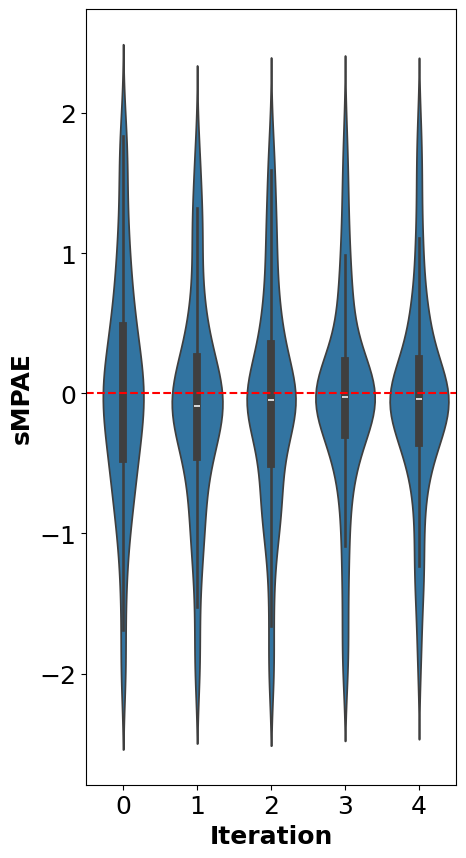

In [35]:
violin_plots_per_iteration(prettify(iteration_data), "mse", "ARMA", pretty_methods["Block_CV"], ["sMPAE"], 10, 5);

#### Time Series Characteristics

In [45]:
from experiment_utils import get_freq, get_csv_filenames, get_univariate_series
from timecave.data_characteristics import get_features

In [48]:
real_data_files = get_csv_filenames('datasets/processed_data')
real_data_files

['c:\\Users\\User\\Desktop\\Project_repos\\tsvalidation\\tsvalidation\\experiments\\datasets/processed_data\\aire_discharge_environment_data.csv',
 'c:\\Users\\User\\Desktop\\Project_repos\\tsvalidation\\tsvalidation\\experiments\\datasets/processed_data\\aire_discharge_weather_data.csv',
 'c:\\Users\\User\\Desktop\\Project_repos\\tsvalidation\\tsvalidation\\experiments\\datasets/processed_data\\air_quality_Rajamahendravaram_13052024.csv',
 'c:\\Users\\User\\Desktop\\Project_repos\\tsvalidation\\tsvalidation\\experiments\\datasets/processed_data\\covid19_17052024.csv',
 'c:\\Users\\User\\Desktop\\Project_repos\\tsvalidation\\tsvalidation\\experiments\\datasets/processed_data\\DailyDelhiClimate_12052024.csv',
 'c:\\Users\\User\\Desktop\\Project_repos\\tsvalidation\\tsvalidation\\experiments\\datasets/processed_data\\ecg_alcohol_17052024.csv',
 'c:\\Users\\User\\Desktop\\Project_repos\\tsvalidation\\tsvalidation\\experiments\\datasets/processed_data\\euro-daily-hist_1999_2024_14052024.cs

In [50]:
d = {}
for file in real_data_files:
    df = pd.read_csv(file)
    freq = get_freq(df, df.columns[0])
    ts_list = get_univariate_series(df)
    d_temp = {}

    for cid, ts in enumerate(ts_list):
        get_features(ts, freq)
        d_temp[cid] = get_features(ts, freq)
    
    file_df = pd.concat(d_temp).reset_index(0).rename(columns={'level_0': 'column_index'})
    d[file] = file_df

pd.concat(d).reset_index(0).rename(columns={'level_0': 'filename'})

,filename,column_index,Mean,Median,Min,Max,Variance,P2P_amplitude,Trend_slope,Spectral_centroid,Spectral_rolloff,Spectral_entropy,Strength_of_trend,Mean_crossing_rate,Median_crossing_rate
0,c:\Users\User\Desktop\Project_repos\tsvalidati...,0,3.236646,0.754264,0.000,43.581806,3.135014e+01,43.581806,0.001134,0.210916,0.466772,0.910387,0.847788,0.286619,0.307205
0,c:\Users\User\Desktop\Project_repos\tsvalidati...,1,3.545170,0.772238,0.000,51.703699,3.747002e+01,51.703699,0.001233,0.211844,0.466772,0.911376,0.842911,0.302454,0.306413
0,c:\Users\User\Desktop\Project_repos\tsvalidati...,2,19.092943,11.050000,3.300,192.000000,4.540312e+02,188.700000,0.008202,0.139688,0.430380,0.738486,1.671502,0.080760,0.063341
0,c:\Users\User\Desktop\Project_repos\tsvalidati...,3,8.188431,4.160000,0.515,85.300000,1.199358e+02,84.785000,0.004134,0.135518,0.425633,0.744166,1.727200,0.090261,0.067300
0,c:\Users\User\Desktop\Project_repos\tsvalidati...,4,0.885597,0.577500,-0.179,4.286000,8.136213e-01,4.465000,0.000307,0.130385,0.423259,0.687693,1.905978,0.090261,0.068092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,c:\Users\User\Desktop\Project_repos\tsvalidati...,0,542.062745,536.000000,412.000,725.000000,3.354341e+03,313.000000,-0.212687,0.064824,0.372549,0.589454,1.200526,0.240157,0.255906
0,c:\Users\User\Desktop\Project_repos\tsvalidati...,1,6767.615686,6565.000000,3224.000,10857.000000,2.082331e+06,7633.000000,-3.613374,0.069888,0.364706,0.537016,1.622677,0.165354,0.200787
0,c:\Users\User\Desktop\Project_repos\tsvalidati...,2,2870.447059,2980.000000,757.000,4822.000000,7.663633e+05,4065.000000,-8.886310,0.089182,0.407843,0.464625,1.816557,0.129921,0.173228
0,c:\Users\User\Desktop\Project_repos\tsvalidati...,3,49.407843,45.000000,32.000,83.000000,1.752611e+02,51.000000,0.099019,0.089059,0.415686,0.507671,1.602214,0.173228,0.200787
